In [358]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [359]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 479 poses.


In [360]:
t_x_data = np.zeros(len(RO_timestamps))
t_y_data = np.zeros(len(RO_timestamps))
t_theta_data = np.zeros(len(RO_timestamps))

for i in range(len(RO_timestamps)):
    t_x_data[i] = RO_se3s[i][0,3]
    t_y_data[i] = RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(RO_se3s[i][0,0])

In [361]:
num_features = 3
num_frames = 6
input_size = num_features * num_frames
output_size = num_features

In [362]:
from model_poses import get_model_pose_prediction_and_error
pred_poses,dim1_data,dim2_data,dim3_data,pred_poses_x,pred_poses_y,pred_poses_theta \
= get_model_pose_prediction_and_error(RO_se3s)

479
478
477


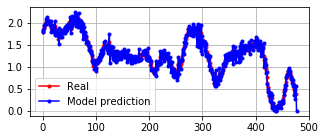

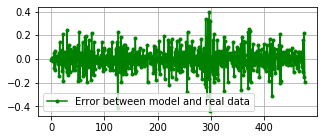

In [363]:
print(len(RO_se3s))
print(len(pred_poses))
print(len(dim1_data))    

plt.figure(figsize=(5,2))
plt.plot(t_x_data[2:],'r.-',label='Real') # cropping first 2 frames here to align plots
plt.plot(pred_poses_x,'b.-',label='Model prediction')
plt.legend()
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(dim1_data,'g.-',label='Error between model and real data')
plt.legend()
plt.grid()

In [364]:
use_toy_data = True
if(use_toy_data):
    from toy_data import make_toy_data
    data_size = 100
    toy_x_model_err,toy_x_data,toy_x_pred = make_toy_data(10,data_size)
    toy_y_model_err,toy_y_data,toy_y_pred = make_toy_data(1,data_size)
    toy_theta_model_err,toy_theta_data,toy_theta_pred = make_toy_data(0.1,data_size)
        
    # hack to allow the rest of the code to remain the same
    t_x_data = toy_x_data
    dim1_data = np.array(toy_x_model_err)
    pred_poses_x = np.array(toy_x_pred)
    t_y_data = toy_y_data
    dim2_data = np.array(toy_y_model_err)
    pred_poses_y = np.array(toy_y_pred)
    t_theta_data = toy_theta_data
    dim3_data = np.array(toy_theta_model_err)
    pred_poses_theta = np.array(toy_theta_pred)

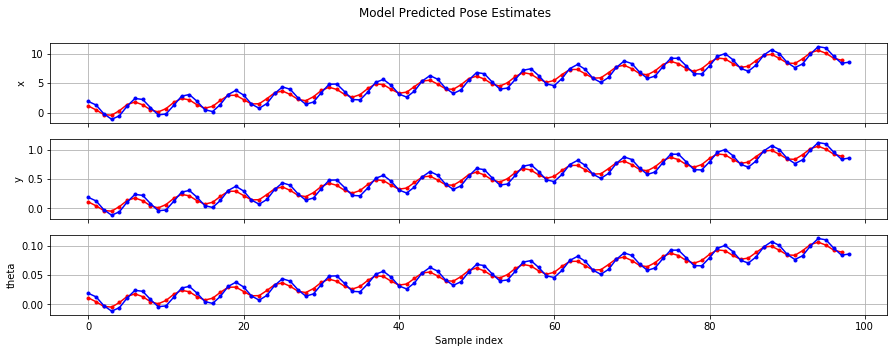

In [365]:
# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Model Predicted Pose Estimates')
axs[0].plot(t_x_data[2:],'r.-')
axs[0].plot(pred_poses_x,'b.-')
axs[0].set(ylabel = 'x')
axs[1].plot(t_y_data[2:],'r.-')
axs[1].plot(pred_poses_y,'b.-')
axs[1].set(ylabel = 'y')
axs[2].plot(t_theta_data[2:],'r.-')
axs[2].plot(pred_poses_theta,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

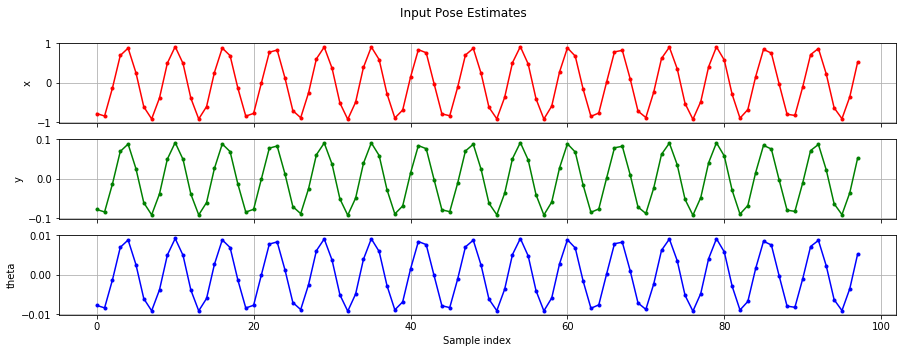

In [366]:
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')
axs[1].plot(dim2_data,'g.-')
axs[1].set(ylabel = 'y')
axs[2].plot(dim3_data,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [367]:
from dataset_prep import prepare_data
train_validate_ratio = 0.8
train_ds,valid_ds = \
prepare_data(dim1_data_scaled,dim2_data_scaled,dim3_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([92, 18])
x_train dimensions: torch.Size([73, 18])
x_valid dimensions: torch.Size([19, 18])
y_data dimensions: torch.Size([92, 3])
y_train dimensions: torch.Size([73, 3])
y_valid dimensions: torch.Size([19, 3])


In [368]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

epochs = 30
lr = 1e-1
batch_size = 30

model = Pose_Logistic()
loss_func = nn.MSELoss()

from network_helpers import *

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = Pose_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)
validation_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.026704583317041397
1 0.013797314837574959
2 0.00897232722491026
3 0.0058967131190001965
4 0.004196321591734886
5 0.002551141893491149
6 0.0018790026661008596
7 0.0011522078420966864
8 0.0007381860632449389
9 0.0004845506337005645
10 0.0003309388121124357
11 0.00020823565137106925
12 0.00015099682786967605
13 8.615283877588809e-05
14 5.785391113022342e-05
15 3.792015922954306e-05
16 2.4518029022146948e-05
17 1.6524380043847486e-05
18 1.0551651939749718e-05
19 7.162237579905195e-06
20 4.63340893475106e-06
21 3.233705683669541e-06
22 1.9548701857274864e-06
23 1.2393412589517538e-06
24 8.14083421118994e-07
25 5.449275590763136e-07
26 3.564192070371064e-07
27 2.3337213406193769e-07
28 1.5690990551320283e-07
29 9.921885180119716e-08


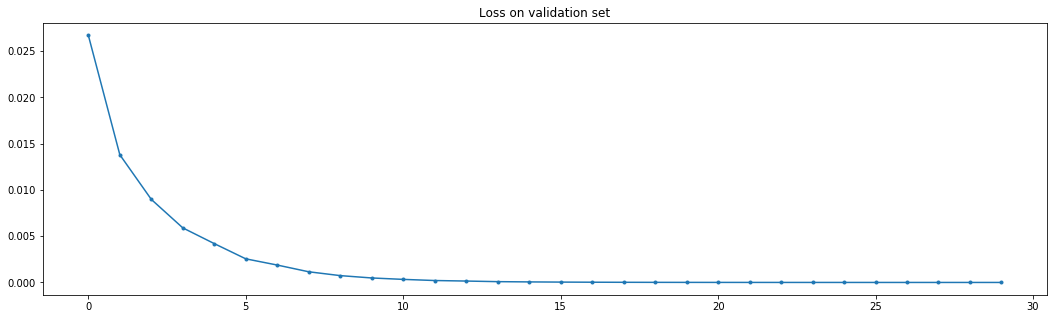

In [369]:
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

In [375]:
from inference import query_at_index
idx = 50
predicted_error_x,predicted_error_y,predicted_error_theta = \
query_at_index(model,dim1_data,dim2_data,dim3_data,num_frames,num_features,idx)

print(predicted_error_x)
print(predicted_error_y)
print(predicted_error_theta)
print('True answer:',dim1_data[idx+num_frames],dim2_data[idx+num_frames],dim3_data[idx+num_frames])
print('...at frame',idx+num_frames)

tensor(-0.4008)
tensor(-0.0401)
tensor(-0.0040)
True answer: -0.4010078644980233 -0.04010078644980264 -0.00401007864498025
...at frame 56


93
98
0.5861433077013072
0.5891035414270817
0.00018805320659915937


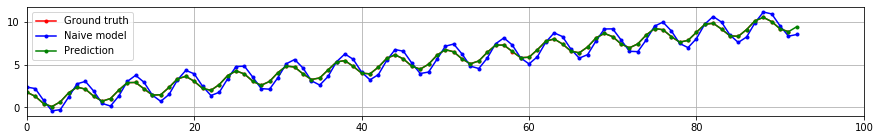

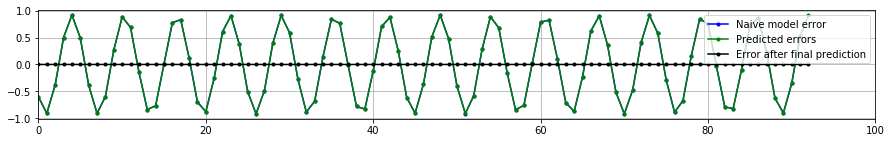

In [372]:
predicted_errors_x = np.zeros(len(dim1_data)-num_frames+1)
final_predictions_x = np.zeros(len(predicted_errors_x))
final_err_x = np.zeros(len(final_predictions_x))

predicted_errors_y = np.zeros(len(dim2_data)-num_frames+1)
final_predictions_y = np.zeros(len(predicted_errors_y))
final_err_y = np.zeros(len(final_predictions_y))

predicted_errors_theta = np.zeros(len(dim3_data)-num_frames+1)
final_predictions_theta = np.zeros(len(predicted_errors_theta))
final_err_theta = np.zeros(len(final_predictions_theta))

print(len(predicted_errors_x))
print(len(dim1_data))

for i in range(len(predicted_errors_x)): 
    predicted_errors_x[i],predicted_errors_y[i],predicted_errors_theta[i] = \
    query_at_index(model,dim1_data,dim2_data,dim3_data,num_frames,num_features,i)

    final_predictions_x[i] = pred_poses_x[i+num_frames] + predicted_errors_x[i]
    final_predictions_y[i] = pred_poses_y[i+num_frames] + predicted_errors_y[i]
    final_predictions_theta[i] = pred_poses_theta[i+num_frames] + predicted_errors_theta[i]
    
# Offset for index at which a valid prediction can be made. Need 4 observations to make a 2-frame prediction, 5 for 3, etc.
pred_offset = 2 + num_frames
# the -1 is because we predict +1 in the future, and so the last prediction has
# no frame from the real data to be compared against
for i in range(len(predicted_errors_x)-1): 
    final_err_x[i] = t_x_data[i+pred_offset] - final_predictions_x[i]
    final_err_y[i] = t_y_data[i+pred_offset] - final_predictions_y[i]
    final_err_theta[i] = t_theta_data[i+pred_offset] - final_predictions_theta[i]

plt.figure(figsize=(15,2))
plt.plot(t_x_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_x[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_x,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

plt.figure(figsize=(15,2))
plt.plot(dim1_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_x,'g.-',label='Predicted errors')
plt.plot(final_err_x,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

print(np.mean(np.abs(dim1_data)))
print(np.mean(np.abs(predicted_errors_x)))
print(np.mean(np.abs(final_err_x)))

0.05861433077013072
0.058910271144091524
2.286099088211784e-05


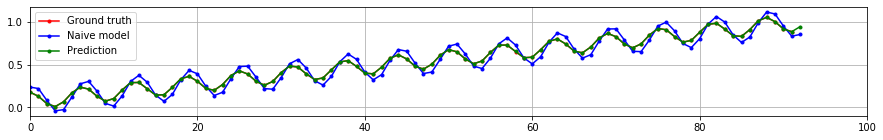

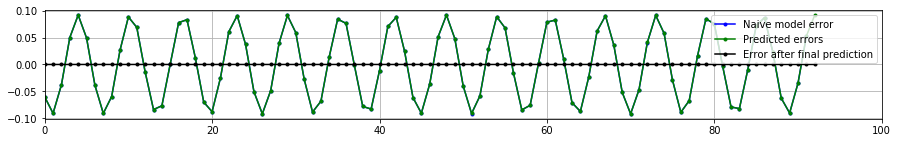

In [373]:
plt.figure(figsize=(15,2))
plt.plot(t_y_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_y[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_y,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

plt.figure(figsize=(15,2))
plt.plot(dim2_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_y,'g.-',label='Predicted errors')
plt.plot(final_err_y,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

print(np.mean(np.abs(dim2_data)))
print(np.mean(np.abs(predicted_errors_y)))
print(np.mean(np.abs(final_err_y)))

0.005861433077013074
0.00589111328384118
1.8798976215461193e-06


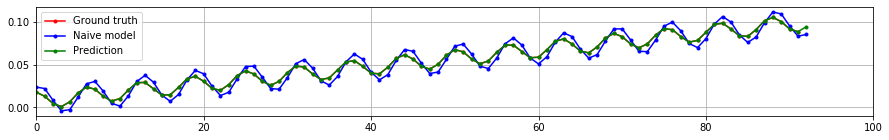

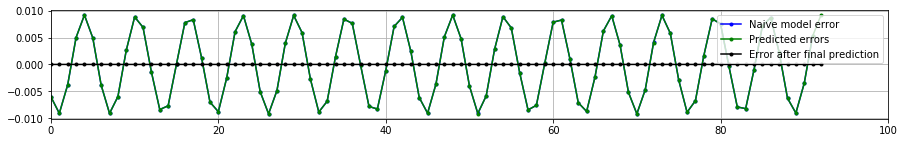

In [374]:
plt.figure(figsize=(15,2))
plt.plot(t_theta_data[pred_offset:],'r.-',label='Ground truth')
plt.plot(pred_poses_theta[num_frames:],'b.-',label='Naive model')
plt.plot(final_predictions_theta,'g.-',label='Prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

plt.figure(figsize=(15,2))
plt.plot(dim3_data[num_frames:],'b.-',label='Naive model error')
plt.plot(predicted_errors_theta,'g.-',label='Predicted errors')
plt.plot(final_err_theta,'k.-',label='Error after final prediction')
plt.legend()
plt.grid()
plt.xlim(0,100)

print(np.mean(np.abs(dim3_data)))
print(np.mean(np.abs(predicted_errors_theta)))
print(np.mean(np.abs(final_err_theta)))